In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
import os
import time
import re
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from scipy.interpolate import griddata
from pearlsim.ml_utilities import *
from pearlsim.results_processing import read_core_flux
import pickle
from sklearn.neighbors import KNeighborsRegressor

In [5]:
def interpolate_core_flux(position_df, core_flux_map, num_neighbors, points_per_cm = 0.25,
                         min_r = 0, max_r = 120, r_bins = 4,
                         min_z = 60, max_z = 369.47, z_bins = 10,
                         plot_group=None):
    num_r_points = int((max_r-min_r)*points_per_cm)
    num_z_points = int((max_z-min_z)*points_per_cm)
    r_array = np.linspace(0+1e-6,120-1e-6, num_r_points)
    z_array = np.linspace(min_z+1e-6,max_z-1e-6,num_z_points)
    r_bin_bounds = np.linspace(min_r,max_r,r_bins+1)
    z_bin_bounds = np.linspace(min_z,max_z,z_bins+1)
    R, Z = np.meshgrid(r_array,z_array)
    knn_model = KNeighborsRegressor(n_neighbors=num_neighbors)
    predicted_df = pd.DataFrame()
    for energy_bin in range(1,18+1):
        bin_label = f"E{energy_bin}"
        related_bins = []
        flux_matrix = np.zeros([r_bins,z_bins])
        r = 0
        z = 0
        for col in list(core_flux_map.axes[0]):
            if bin_label == col[-len(bin_label):]:
                flux_matrix[r,z] = core_flux_map[col]
                r += 1
            if r == 4:
                z += 1
                r = 0


        point_fluxes = np.zeros([num_r_points,num_z_points])

        for r_ind in range(len(r_array)):
            for z_ind in range(len(z_array)):
                r = r_array[r_ind]
                z = z_array[z_ind]
                r_bin = np.searchsorted(r_bin_bounds, r)-1
                z_bin = np.searchsorted(z_bin_bounds, z)-1
                point_fluxes[r_ind,z_ind] = flux_matrix[r_bin,z_bin]
        training_data = pd.DataFrame({"radius":R.T.flatten(), "height":Z.T.flatten()})
        target_data = pd.DataFrame({"flux":point_fluxes.flatten()})
        knn_model.fit(training_data, target_data)
        predicted = knn_model.predict(position_df)
        if type(plot_group) == int:
            if energy_bin == plot_group:
                plt.figure()
                plt.imshow(np.rot90(point_fluxes,1))
                plt.show()
                predicted_grid = knn_model.predict(training_data).reshape(num_r_points,num_z_points)
                plt.figure()
                plt.imshow(np.rot90(predicted_grid,1))
                plt.show()

        predicted_df[f"{bin_label}_flux_interpolated"] = pd.Series(predicted[:,0])
    return predicted_df

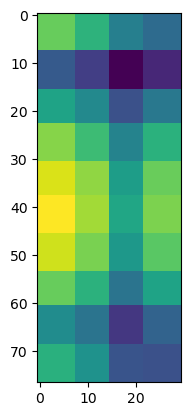

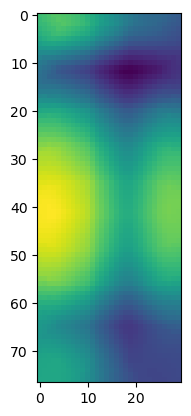

File gFHR_equilibrium_training_1.serpent_det0.m has an average 12.02% uncertainty.


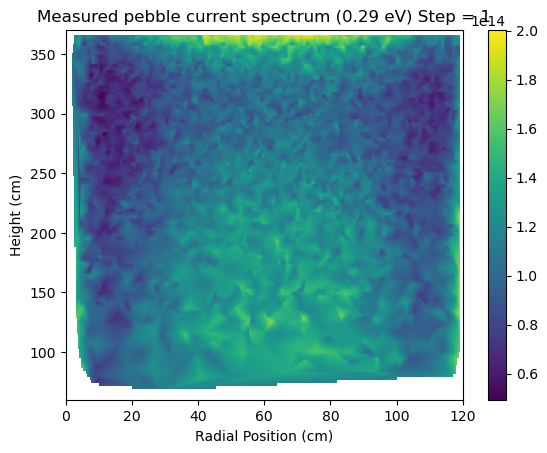

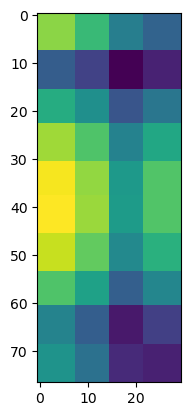

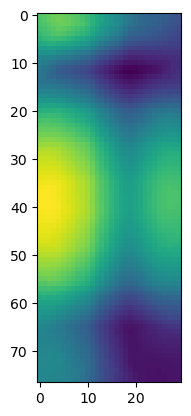

File gFHR_equilibrium_training_11.serpent_det0.m has an average 7.55% uncertainty.


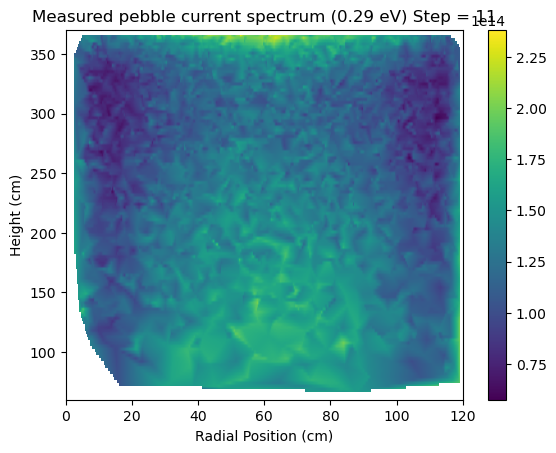

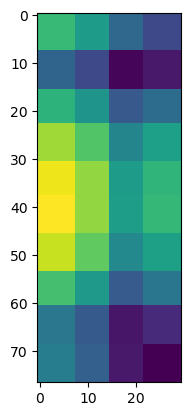

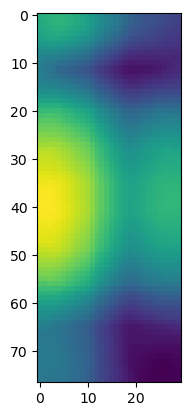

File gFHR_equilibrium_training_22.serpent_det0.m has an average 8.55% uncertainty.


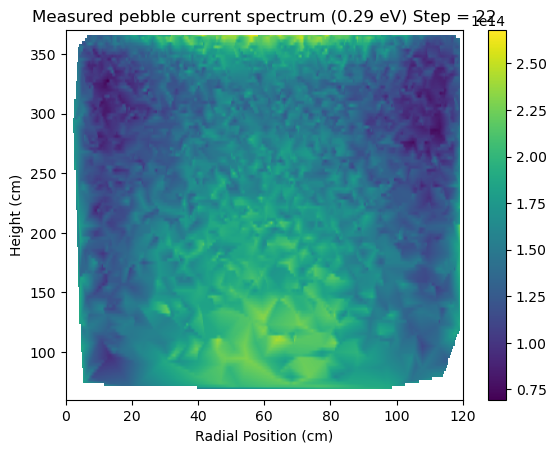

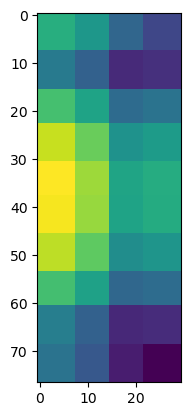

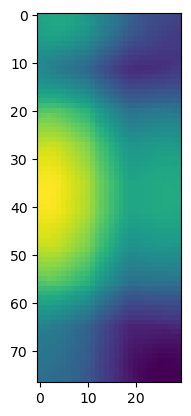

File gFHR_equilibrium_training_35.serpent_det0.m has an average 10.1% uncertainty.


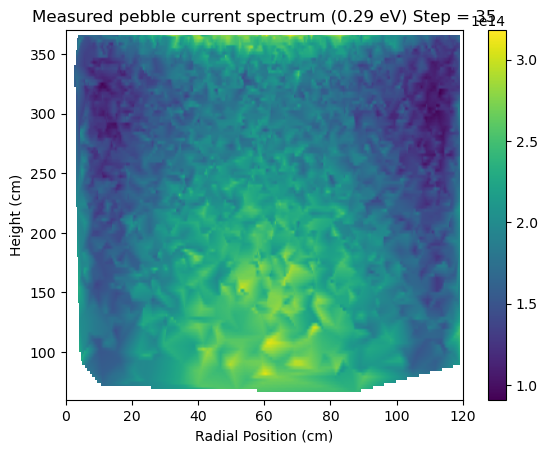

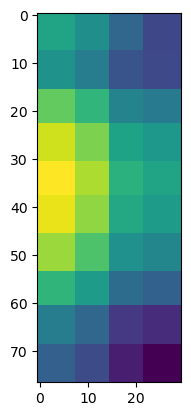

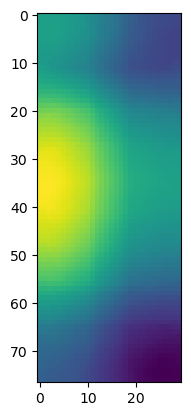

File gFHR_equilibrium_training_60.serpent_det0.m has an average 8.13% uncertainty.


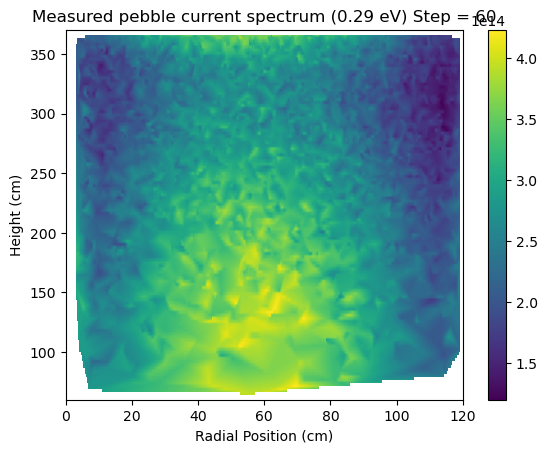

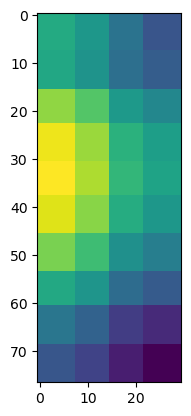

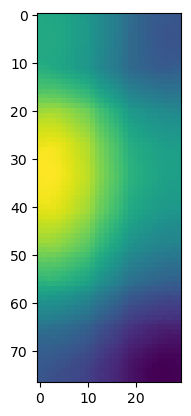

File gFHR_equilibrium_training_85.serpent_det0.m has an average 7.81% uncertainty.


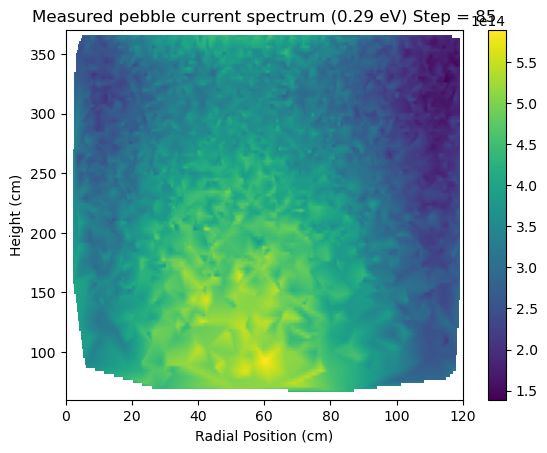

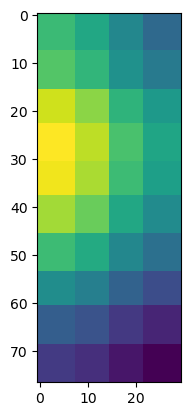

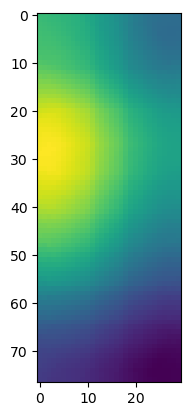

File gFHR_equilibrium_training_140.serpent_det0.m has an average 16.13% uncertainty.


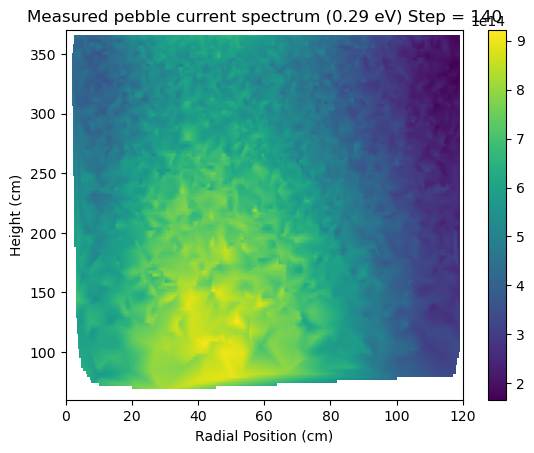

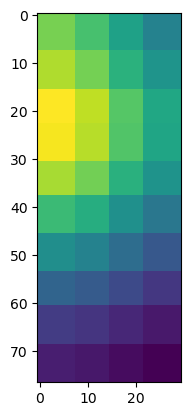

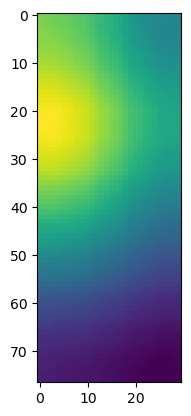

File gFHR_equilibrium_training_200.serpent_det0.m has an average 6.49% uncertainty.


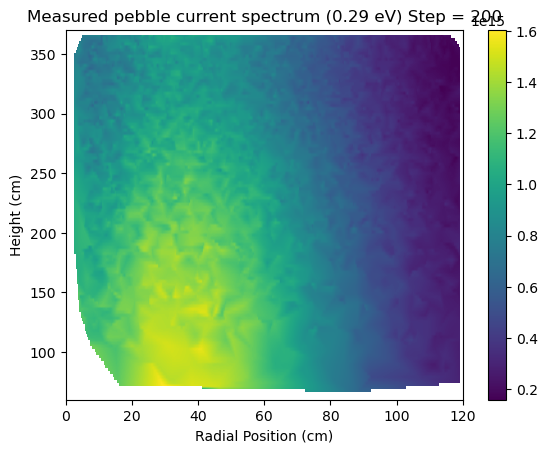

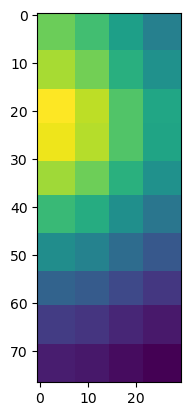

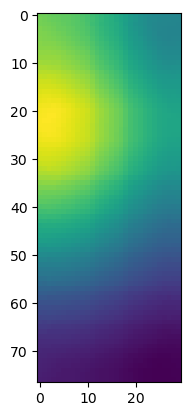

File gFHR_equilibrium_training_250.serpent_det0.m has an average 20.52% uncertainty.


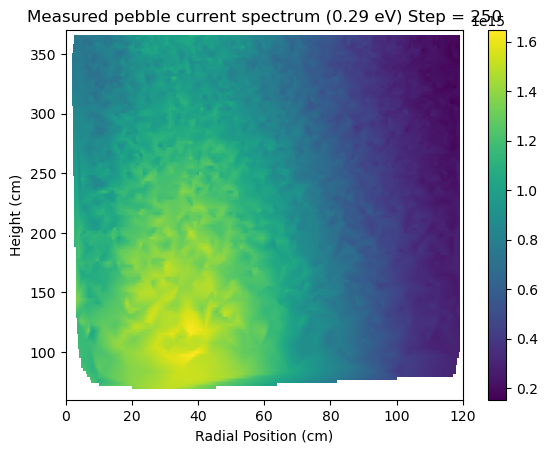

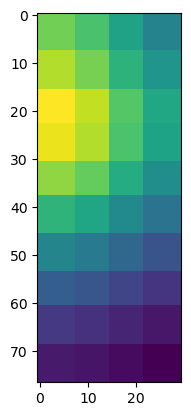

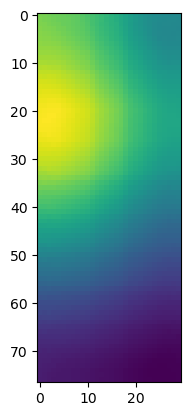

File gFHR_equilibrium_training_300.serpent_det0.m has an average 6.47% uncertainty.


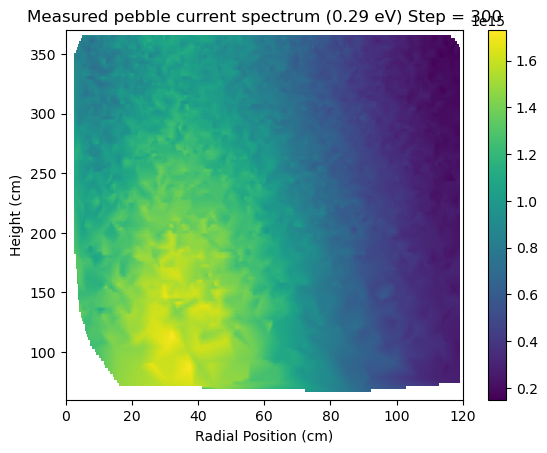

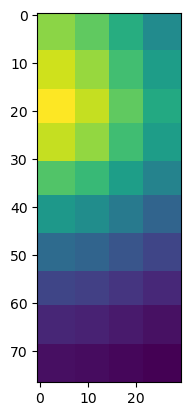

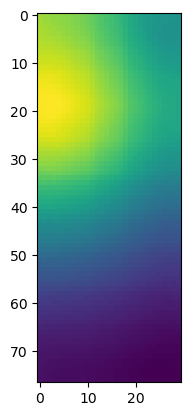

File gFHR_equilibrium_training_350.serpent_det0.m has an average 6.45% uncertainty.


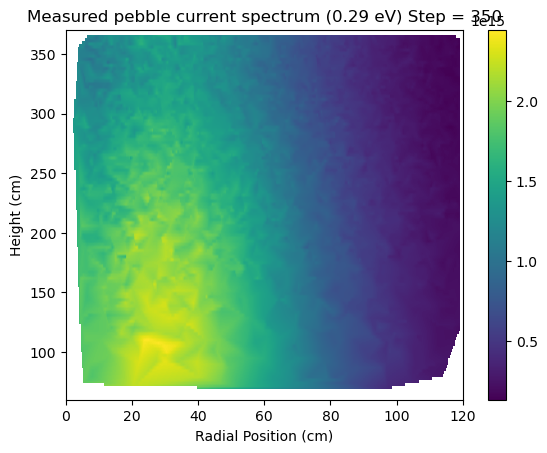

In [22]:
training_steps = [1, 11, 22, 35, 60, 85, 140, 200, 250, 300, 350]
num_neighbors = 81
all_features = pd.DataFrame([])
all_targets = pd.DataFrame([])
last_current_grid = []
for i in training_steps:
    # Load the Serpent Detector file, a matlab format file that has pebble surface flux
    # and overall core flux. 
    det_name = f"gFHR_equilibrium_training_{i}.serpent_det0.m"
    
    # Load the auxiliary feature file, which are additionally features I included from
    # the model that tell you more about the respective pebble for each surface
    aux_name = f"current_auxiliary_features{i}.csv"
    features, targets, pebble_ids, avg_uncertainty = read_det_file("training_data/"+det_name, 
                                                                    normalize_and_label=True)
    if len(all_targets) > 0:
        assert last_current_grid.equals(targets.columns)
    
    last_current_grid = targets.columns
    energy_group = 1
    rename_headers = {}
    for energy in last_current_grid:
        rename_headers[energy] = f"current_E{energy_group}"
        energy_group += 1
    targets = targets.rename(columns=rename_headers)


    aux_features = pd.read_csv("training_data/"+aux_name, index_col=0)
    
    # Read the pebble power file and grab the corresponding power values
    pow_name = f"pebble_positions_{i}.csv_pow0.m"
    pow_data = pd.read_csv("training_data/"+pow_name, delimiter='\s+', 
                           names=['x','y','z','rad','universe','power','unc'])
    targets['power'] = pow_data['power'].iloc[pebble_ids].reset_index().drop(columns='index')
    features = aux_features.join(features)
    
    # Convert coordinates to 2D cylindrical, since the flux map is symmetrical
    features['radius'] = round(np.sqrt(features['x']**2+features['y']**2),1)
    features['height'] = round(features['z'],1)
    features = features.drop(columns=['x','y','z'])
    
    interpolated_flux = interpolate_core_flux(features[['radius','height']], features.iloc[0], num_neighbors, plot_group=1)
    features = features.join(interpolated_flux)
    features['step'] = i
    
    print(f"File {det_name} has an average {round(avg_uncertainty*100,2)}% uncertainty.")
    all_features = pd.concat([all_features, features])
    all_targets = pd.concat([all_targets, targets])
    
    R = np.arange(0, 120, 1)
    Z = np.arange(60, 370, 1)
    X, Y = np.meshgrid(R, Z)
    r = features['radius'].to_numpy()
    h = features['height'].to_numpy()
    parameter = "current_E1"
    param_interpolated = griddata((r,h), targets[parameter], (X, Y), rescale=True)
    plt.imshow(np.rot90(param_interpolated,1), extent=(0,120,60,370), aspect='auto')#, vmin=5E13, vmax=1E15)
    plt.colorbar()
    plt.title(f"Measured pebble current spectrum (0.29 eV) Step = {i}")
    plt.xlabel("Radial Position (cm)")
    plt.ylabel("Height (cm)")
    plt.show()

# For clarity, re-order the radius and height columns to be first and save
headers = all_features.columns.to_list()
headers.remove("radius")
headers.remove("height")
all_features = all_features[["radius"]+["height"]+headers].reset_index(drop=True)
all_targets = all_targets.reset_index(drop=True)

In [26]:
display(all_features.iloc[-5:])
display(all_targets.iloc[-5:])

,radius,height,cs137,xe135,u235,binR1Z1E1,binR2Z1E1,binR3Z1E1,binR4Z1E1,binR1Z2E1,...,E10_flux_interpolated,E11_flux_interpolated,E12_flux_interpolated,E13_flux_interpolated,E14_flux_interpolated,E15_flux_interpolated,E16_flux_interpolated,E17_flux_interpolated,E18_flux_interpolated,step
43995,58.5,179.1,0.000050,3.667876e-08,0.002811,2.253014e+20,2.142229e+20,1.847288e+20,1.549450e+20,3.434956e+20,...,8.761358e+17,1.994917e+17,8.475642e+15,1.787767e+15,3.019222e+14,3.825242e+13,2.106329e+13,8.803311e+12,6.101239e+11,350
43996,75.4,89.3,0.000124,4.168309e-10,0.000035,2.253014e+20,2.142229e+20,1.847288e+20,1.549450e+20,3.434956e+20,...,2.056208e+17,4.697352e+16,2.021113e+15,4.305961e+14,7.349623e+13,9.426729e+12,5.216922e+12,2.175545e+12,1.513777e+11,350
43997,52.2,324.3,0.000122,1.583272e-09,0.000130,2.253014e+20,2.142229e+20,1.847288e+20,1.549450e+20,3.434956e+20,...,2.960803e+18,6.868043e+17,3.025790e+16,6.532861e+15,1.121866e+15,1.442922e+14,7.997620e+13,3.359659e+13,2.340820e+12,350
43998,114.4,124.6,0.000084,1.951481e-08,0.001557,2.253014e+20,2.142229e+20,1.847288e+20,1.549450e+20,3.434956e+20,...,2.613954e+17,5.985670e+16,2.619845e+15,5.705248e+14,9.917943e+13,1.295472e+13,7.248513e+12,3.061757e+12,2.157023e+11,350
43999,91.1,167.0,0.000124,2.134337e-10,0.000013,2.253014e+20,2.142229e+20,1.847288e+20,1.549450e+20,3.434956e+20,...,5.916431e+17,1.355528e+17,5.851130e+15,1.256172e+15,2.155663e+14,2.778512e+13,1.543509e+13,6.485590e+12,4.532945e+11,350


,current_E1,current_E2,current_E3,current_E4,current_E5,current_E6,current_E7,current_E8,current_E9,current_E10,current_E11,current_E12,current_E13,current_E14,current_E15,current_E16,current_E17,current_E18,power
43995,1.612400e+15,3.833830e+15,3.608670e+15,1.852630e+15,3.063580e+14,7.938810e+13,2.693710e+14,3.342130e+14,4.339780e+14,2.524770e+14,1.185790e+15,2.361930e+15,3.239130e+14,1.526050e+15,8.136170e+14,3.487110e+14,6.467360e+14,2.320140e+14,7872.6700
43996,1.574190e+15,3.510330e+15,3.531940e+15,1.745730e+15,3.548930e+14,9.333640e+13,2.727840e+14,4.071240e+14,4.770560e+14,2.985580e+14,1.387620e+15,2.782090e+15,4.493270e+14,1.996390e+15,1.006660e+15,4.347560e+14,7.474500e+14,3.048320e+14,101.2900
43997,3.302340e+14,8.090940e+14,8.247460e+14,3.493140e+14,3.249070e+13,1.541190e+13,2.879100e+13,5.518250e+13,7.422030e+13,3.471460e+13,1.522600e+14,2.814420e+14,3.797200e+13,1.937700e+14,1.054080e+14,3.249750e+13,6.249970e+13,1.898940e+13,68.5903
43998,1.310400e+15,2.987010e+15,2.903520e+15,1.393020e+15,1.553830e+14,6.070740e+13,1.662380e+14,2.405380e+14,2.561350e+14,1.736680e+14,7.692230e+14,1.380810e+15,1.847360e+14,9.453930e+14,4.614180e+14,2.624660e+14,4.620700e+14,1.764480e+14,3354.6100
43999,1.453990e+15,3.275280e+15,3.075710e+15,1.572020e+15,2.435610e+14,9.185030e+13,2.336300e+14,3.346200e+14,4.542010e+14,2.579080e+14,1.128880e+15,1.997660e+15,2.944750e+14,1.385660e+15,6.523450e+14,3.793250e+14,6.994110e+14,2.067290e+14,37.2269


In [27]:
all_features.to_csv("training_data/current_data.csv")
all_targets.to_csv("training_data/current_target.csv")